# Constructing Data

## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns

In [4]:
from scipy.optimize import newton
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
os.chdir('/Users/maris/Documents/FE800')

## Import Data

In [10]:
raw_data = pd.read_pickle("raw_data.pkl")
raw_data = raw_data.sort_values("trd_datetime")
raw_data.head()

cusip_id  bond_sym_id company_symbol          bsym trd_exctn_dt  \
15069458  871829BF3   SYY4509019            SYY  BBG00GZTSD12   2018-07-01   
13757251  98978VAL7   PFE4538719            PFE  BBG00HMQT197   2018-07-02   
168819    037833DB3  AAPL4538816           AAPL  BBG00HMQPZ05   2018-07-02   
12504563  606822AR5   MTU4520249            MTU  BBG00H5RFN00   2018-07-02   
3857278   172967KA8     C4292071              C  BBG00B2XQKX1   2018-07-02   

         trd_exctn_tm   trans_dt  msg_seq_nb trc_st remuneration  \
15069458     23:50:32 2018-07-02         499      M            M   
13757251     01:17:48 2018-07-02         502      M            M   
168819       02:37:16 2018-07-02         124      M            M   
12504563     02:43:56 2018-07-02         503      M            M   
3857278      03:35:11 2018-07-02         574      M            M   

          ascii_rptd_vol_tx frmt_cd  rptd_pr yld_sign_cd    yld_pt asof_cd  \
15069458          5000000.0       A   94.111         NaN  4.034690       A   
13757251          5000000.0       A   92.248         NaN  4.017301     NaN   
168819              10000.0       A   95.090         NaN  3.530293     NaN   
12504563           100000.0       A   95.448         NaN  3.887961     NaN   
3857278            110000.0       A   98.817         NaN  4.607907     NaN   

         sale_cndtn_cd sale_cndtn2_cd spcl_trd_fl side  chng_cd  rptd_high_pr  \
15069458           NaN            NaN         NaN    S        0           NaN   
13757251           NaN            NaN         NaN    S        7           NaN   
168819             NaN            NaN         NaN    S        7           NaN   
12504563           NaN            NaN         NaN    S        7           NaN   
3857278            NaN            NaN         NaN    S        2           NaN   

          high_yld_pt  rptd_low_pr  low_yld_pt  rptd_last_pr  lsal_yld_pt  \
15069458          NaN          NaN         NaN           NaN          NaN   
13757251          NaN          NaN         NaN           NaN          NaN   
168819            NaN          NaN         NaN           NaN          NaN   
12504563          NaN          NaN         NaN           NaN          NaN   
3857278           NaN          NaN         NaN           NaN          NaN   

         orig_dis_dt  orig_msg_seq_nb function rptg_party_type  \
15069458         NaN              NaN      NaN               D   
13757251         NaN              NaN      NaN               D   
168819           NaN              NaN      NaN               D   
12504563         NaN              NaN      NaN               D   
3857278          NaN              NaN      NaN               D   

         contra_party_type        trd_datetime  
15069458                 C 2018-07-01 23:50:32  
13757251                 C 2018-07-02 01:17:48  
168819                   C 2018-07-02 02:37:16  
12504563                 A 2018-07-02 02:43:56  
3857278                  A 2018-07-02 03:35:11

In [11]:
data = raw_data[["cusip_id", "trd_datetime", "trans_dt", "rptd_pr", "ascii_rptd_vol_tx"]]
data = data.rename(columns = {"cusip_id":"cusip", "rptd_pr":"trd_px", "ascii_rptd_vol_tx":"volume", "trans_dt":"trd_dt"})
data = data.reset_index().drop(["index"], axis = 1)
data.head()

cusip        trd_datetime     trd_dt  trd_px     volume
0  871829BF3 2018-07-01 23:50:32 2018-07-02  94.111  5000000.0
1  98978VAL7 2018-07-02 01:17:48 2018-07-02  92.248  5000000.0
2  037833DB3 2018-07-02 02:37:16 2018-07-02  95.090    10000.0
3  606822AR5 2018-07-02 02:43:56 2018-07-02  95.448   100000.0
4  172967KA8 2018-07-02 03:35:11 2018-07-02  98.817   110000.0

In [686]:
df_characteristics = pd.read_pickle("df_characteristics.pkl")
df_characteristics = df_characteristics.drop(["Notional", "Par", "Liquidity_Score"], axis = 1)
df_characteristics.head()

Name      Cusip   Maturity      TTM  Coupon  \
0  PFIZER INVESTMENT ENTERPRISES PTE  716973AG7 2053-05-19  29.5534    5.30   
1       ANHEUSER-BUSCH COMPANIES LLC  03522AAJ9 2046-02-01  22.2548    4.90   
2        GOLDMAN SACHS GROUP INC/THE  38141GFD1 2037-10-01  13.9123    6.75   
3                    CVS HEALTH CORP  126650CZ1 2048-03-25  24.4000    5.05   
4                   T-MOBILE USA INC  87264ABF1 2030-04-15   6.4438    3.88   

   Weight  Amount_Issued               Industry       Location Accrual_Date  \
0    0.30     6000000000  Consumer Non-Cyclical  United States   2023-05-19   
1    0.28     9518964000  Consumer Non-Cyclical        Belgium   2019-02-01   
2    0.25     5545000000                Banking  United States   2007-10-03   
3    0.22     8000000000  Consumer Non-Cyclical  United States   2018-03-09   
4    0.21     7000000000         Communications  United States   2021-04-15   

  Effective_Date Moody_Rating S&P_Rating Fitch_Rating    TTM_Range      TFI  \
0     2023-05-19           A1         A+            A    20+ Years   0.4685   
1     2019-05-13           A3         A-         None    20+ Years   4.4877   
2     2007-10-03         Baa2        BBB         BBB+  10-15 Years  16.1041   
3     2018-03-09         Baa2        BBB         None    20+ Years   5.6658   
4     2021-05-21         Baa2        BBB         BBB+    5-7 Years   2.4630   

          Company Ticker            Sector Sector Ticker  
0          Pfizer    PFE       Health Care           XLF  
1  Anheuser-Busch    BUD  Consumer Staples           XLV  
2   Goldman Sachs     GS        Financials           XLK  
3      Cvs Health    CVS       Health Care           XLF  
4    T-Mobile Usa   TMUS    Communications           XLY

In [217]:
macro_factors = pd.read_pickle("macro_factors.pkl")
macro_factors.head()

EFFR  Lower_Target  Upper_Target  1YRT  2YRT  3YRT  5YRT  7YRT  \
2018-07-02  1.91          1.75           2.0  2.34  2.57  2.65  2.75  2.83   
2018-07-03  1.91          1.75           2.0  2.33  2.53  2.63  2.72  2.79   
2018-07-05  1.91          1.75           2.0  2.32  2.55  2.65  2.74  2.80   
2018-07-06  1.91          1.75           2.0  2.34  2.53  2.64  2.71  2.78   
2018-07-09  1.91          1.75           2.0  2.34  2.57  2.66  2.75  2.82   

            10YRT  30YRT         SPY         LQD  
2018-07-02   2.87   2.99  271.859985  114.239998  
2018-07-03   2.83   2.96  270.899994  114.660004  
2018-07-05   2.84   2.95  273.109985  115.019997  
2018-07-06   2.82   2.94  275.420013  115.180000  
2018-07-09   2.86   2.96  277.899994  115.260002

In [76]:
df_close = pd.read_pickle("df_close.pkl")
df_close.head()

AAPL       ABBV        ABT       ACGL        ADBE  \
Date                                                                          
2018-07-02 00:00:00  44.660526  72.200851  55.612400  26.629999  243.259995   
2018-07-03 00:00:00  43.882687  72.588554  55.439175  26.760000  242.009995   
2018-07-05 00:00:00  44.235817  73.263176  55.913250  26.930000  244.179993   
2018-07-06 00:00:00  44.849014  75.155235  56.669937  27.280001  248.190002   
2018-07-09 00:00:00  45.471741  75.248299  56.925217  27.889999  249.770004   

                           ADI        ADM         ADP        ADSK        AEE  \
Date                                                                           
2018-07-02 00:00:00  87.108955  39.269852  120.948914  131.899994  53.183754   
2018-07-03 00:00:00  85.480942  39.643181  119.872704  131.600006  53.192432   
2018-07-05 00:00:00  87.190369  40.233578  119.917526  132.800003  53.470440   
2018-07-06 00:00:00  87.913948  40.554813  120.374924  135.110001  53.887424   
2018-07-09 00:00:00  87.895851  41.041019  120.643982  134.970001  52.097832   

                           AEP        AER        AES        AGR        AIG  \
Date                                                                         
2018-07-02 00:00:00  58.559010  53.770000  11.096852  43.560982  46.011150   
2018-07-03 00:00:00  58.935173  54.139999  10.987064  43.716797  46.278454   
2018-07-05 00:00:00  59.461842  54.480000  10.953287  44.012012  46.494022   
2018-07-06 00:00:00  59.821293  54.590000  10.978618  44.389236  46.882042   
2018-07-09 00:00:00  57.572571  55.349998  10.666151  42.822941  47.908157   

                            AL        ALL       ALLY       AMAT      AMCR  \
Date                                                                        
2018-07-02 00:00:00  38.018368  80.700890  22.660580  42.799240  8.286686   
2018-07-03 00:00:00  38.154633  80.903374  22.575615  41.974743  8.010463   
2018-07-05 00:00:00  38.408997  80.938583  22.771036  42.574375  8.191979   
2018-07-06 00:00:00  38.318157  81.132286  22.898485  43.220867  8.247224   
2018-07-09 00:00:00  39.099422  82.399963  23.552731  43.586262  8.247224   

                           AMGN         AMP         AMT       AMZN  \
Date                                                                 
2018-07-02 00:00:00  158.088074  125.273659  128.505890  85.689003   
2018-07-03 00:00:00  158.446426  123.824104  127.049103  84.697998   
2018-07-05 00:00:00  159.854218  125.362564  129.394165  84.986504   
2018-07-06 00:00:00  162.968353  125.993950  129.518509  85.531502   
2018-07-09 00:00:00  165.664444  129.622223  126.294052  86.950996   

                            AON         APD        APH       APTV       ARCC  \
Date                                                                           
2018-07-02 00:00:00  130.580215  137.692062  41.299652  90.947884   9.936111   
2018-07-03 00:00:00  130.418472  137.258163  41.110008  89.724060   9.936111   
2018-07-05 00:00:00  131.503113  137.957733  41.631531  91.855873   9.960272   
2018-07-06 00:00:00  132.835052  138.710449  41.811695  93.030365   9.966312   
2018-07-09 00:00:00  135.603638  139.817352  42.371140  94.283791  10.008595   

                            ARE  ATH-PA        ATO       ATVI        AVGO  \
Date                                                                        
2018-07-02 00:00:00  107.354958     NaN  79.792389  74.544205  202.352249   
2018-07-03 00:00:00  108.183525     NaN  80.613823  73.193756  200.044891   
2018-07-05 00:00:00  109.037720     NaN  81.302734  73.492790  205.152817   
2018-07-06 00:00:00  109.054787     NaN  81.762039  74.457390  207.058853   
2018-07-09 00:00:00  109.507515     NaN  79.324272  74.119766  206.849869   

                           AWK        AXP        AZN         AZO          BA  \
Date                                                                           
2018-07-02 00:00:00  78.946709  91.516800  30.145592  667.809998  323.46

In [77]:
df_volume = pd.read_pickle("df_volume.pkl")
df_volume.head()

AAPL     ABBV      ABT     ACGL     ADBE      ADI  \
Date                                                                         
2018-07-02 00:00:00  70925200  3854500  4365200  1249400  4127400  2058400   
2018-07-03 00:00:00  55819200  2452400  2245200   537300  1307700   876000   
2018-07-05 00:00:00  66416800  4744000  4065200   926200  1863400  1977700   
2018-07-06 00:00:00  69940800  5867400  3647900  1482600  1889700  1551000   
2018-07-09 00:00:00  79026400  5953100  3654900  1858000  2170700  1861300   

                         ADM      ADP     ADSK      AEE      AEP      AER  \
Date                                                                        
2018-07-02 00:00:00  3800100  2228800  1308300  1203500  2211700  1224800   
2018-07-03 00:00:00  1508000  2794200   928100   677000  2132100   509300   
2018-07-05 00:00:00  2556000  2593400  1708200  1046500  4157000  1197000   
2018-07-06 00:00:00  2306800  3895900  1159200  1171600  2315100   824600   
2018-07-09 00:00:00  3410300  2750300  1761500  1782100  4302600   941600   

                         AES     AGR      AIG      AL      ALL     ALLY  \
Date                                                                      
2018-07-02 00:00:00  7761300  305500  5198800  811000  1789500  4001000   
2018-07-03 00:00:00  3846200  255500  1970500  359300   836500  1143100   
2018-07-05 00:00:00  5292000  483300  2743800  597300  1133800  2933200   
2018-07-06 00:00:00  5476100  311500  2212400  323500  1559600  2047500   
2018-07-09 00:00:00  7724900  616400  4706400  379900  1391200  3105200   

                         AMAT  AMCR     AMGN      AMP      AMT      AMZN  \
Date                                                                       
2018-07-02 00:00:00  11042900     0  2069800   721400  1559500  63714000   
2018-07-03 00:00:00   7538500   900  1348000   337400  1669600  43546000   
2018-07-05 00:00:00   8950700   700  1801000   996700  1512400  59662000   
2018-07-06 00:00:00  11467600   100  2751600   988600  1376600  53006000   
2018-07-09 00:00:00   9727700     0  3065500  1217600  2334400  60240000   

                        AON      APD      APH     APTV     ARCC     ARE  \
Date                                                                      
2018-07-02 00:00:00  777600  1110100  2303000  1684400  3165900  542700   
2018-07-03 00:00:00  411000   346800   859200   867800   684500  319600   
2018-07-05 00:00:00  710800  1140600  1557200  1824600  1304500  825000   
2018-07-06 00:00:00  837400   718800  1623600  1390900  1880700  480300   
2018-07-09 00:00:00  984600   744100  1627400  1317000  1953600  769000   

                     ATH-PA     ATO     ATVI     AVGO     AWK      AXP  \
Date                                                                     
2018-07-02 00:00:00     NaN  353200  3324929  3336900  674900  3148700   
2018-07-03 00:00:00     NaN  373600  2028270  1159100  336000  2041200   
2018-07-05 00:00:00     NaN  328000  7998765  2529900  682700  2385500   
2018-07-06 00:00:00     NaN  271100  2954209  2311200  608300  1996600   
2018-07-09 00:00:00     NaN  564400  4518442  1795500  869400  4991700   

                         AZN     AZO       BA       BAC  BAM      BAX    BBAR  \
Date                                                                            
2018-07-02 00:00:00  4119700  317000  2820700  52534300  NaN  1391900  942900   
2018-07-03 00:00:00  1909600  143400  1464400  40599000  NaN  1531800  647000   
2018-07-05 00:00:00  3715700  144100  2427900  44506800  NaN  1595700  619700   
2018-07-06 00:00:00  2736100  145700  2105100  39424900  NaN  1440100  282000   
2018-07-09 00:00:00  2062500  218000  3128700  61758900  NaN  1564500  361900   

                         BCE      BCS     BDX       BG      BHF      BHP  \
Date                                                                       
2018-07-02 00:00:00   654100  2289600  827893  1032300  2140000  3397751   
2018-07-03 00:00:00   605800  1433000 

In [508]:
df_sector_etfs = pd.read_pickle("df_sector_etfs.pkl")
df_sector_etfs = df_sector_etfs.drop([pd.Timestamp("2022-12-30")])
df_sector_etfs.head()

XLB        XLC        XLE        XLF        XLI        XLK  \
Date                                                                           
2018-07-02  51.815945  47.558662  57.704594  23.967846  65.343208  66.198044   
2018-07-03  51.726242  46.976589  58.067070  23.752563  65.133850  65.414146   
2018-07-05  52.174786  47.692253  58.005363  23.806385  65.452423  66.339729   
2018-07-06  52.434948  48.446110  58.360157  23.923000  65.679985  67.114189   
2018-07-09  52.901424  48.722832  59.231655  24.470165  66.899651  67.624207   

                  XLP       XLRE        XLU        XLV         XLY  
Date                                                                
2018-07-02  44.529411  27.258997  44.282078  76.473434  103.793686  
2018-07-03  44.633709  27.418257  44.408997  76.656136  103.272079  
2018-07-05  45.250839  27.778694  44.645935  77.450844  103.784180  
2018-07-06  45.389912  27.896046  44.992886  78.565231  104.599747  
2018-07-09  45.216068  27.636196  43.605110  79.140717  105.851517

## Data

In [564]:
daily_close_prices = data.groupby(["cusip", "trd_dt"])["trd_px"].agg({"last"})
daily_close_prices.head()

last
cusip     trd_dt             
00130HCG8 2021-08-16  101.067
          2021-08-20  101.009
          2021-08-23  101.369
          2021-08-24  101.395
          2021-08-25  100.530

In [565]:
df_daily = daily_close_prices.unstack("cusip")
df_daily = df_daily.sort_index()
df_daily.columns = df_daily.columns.droplevel(0)
df_daily = df_daily.replace(.1, 147.647)
df_daily = df_daily.ffill()
df_daily.head()

cusip       00130HCG8  00130HCH6  00206RBH4  00206RBK7  00206RCP5  00206RCQ3  \
trd_dt                                                                         
2018-07-02        NaN        NaN     86.132  85.280000     92.446    91.4532   
2018-07-03        NaN        NaN     86.821  85.863000     93.350    90.3120   
2018-07-05        NaN        NaN     86.730  85.979573     93.282    92.2920   
2018-07-06        NaN        NaN     88.675  86.610000     93.000    91.0250   
2018-07-09        NaN        NaN     89.397  87.282000     93.380    91.4124   

cusip        00206RCU4  00206RDJ8  00206RDK5   00206RDQ2   00206RDR0  \
trd_dt                                                                 
2018-07-02  100.697000  88.308500  86.652000   98.191000   98.845000   
2018-07-03  101.772049  86.951288  86.373563   98.533103   99.710000   
2018-07-05  102.214000  87.437000  87.390000   99.932742  100.278997   
2018-07-06  102.214000  87.760000  88.016000   98.881000  100.236000   
2018-07-09  102.635000  88.315000  88.016000  100.233900  100.858000   

cusip       00206RGL0  00206RGQ9  00206RHJ4  00206RHK1  00206RHW5  00206RJX1  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RJY9  00206RJZ6  00206RKA9  00206RKB7  00206RKE1  00206RKG6  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RKH4  00206RKJ0  00206RLJ9  00206RLV2  00206RMM1  00206RMN9  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RMT6  00217GAB9  00217GAC7  002824BF6  002824BG4   002824BH2  \
trd_dt                                                                          
2018-07-02        NaN        NaN        NaN     98.213    105.716  107.826000   
2018-07-03        NaN        NaN        NaN     98.600    106.012  108.997437   
2018-07-05        NaN        NaN        NaN     98.601    106.840  109.156000   
2018-07-06        NaN        NaN        NaN     99.101    107.087  109.845000   
2018-07-09        NaN        NaN        NaN     98.947    107.073  110.156000   

cusip       00287YAM1  00287YAR0  00287YAS8  00287YAV1  00287YAW9  00287YBD0  \
trd_dt                                                                         
2018-07-02     95.296     98.118     99.255  95.429000     95.198        NaN   
2018-07-03     95.393     98.382     99.255  96.102142     95.198        NaN   
2018-07-05     96.091     99.409     99.767  96.466230     96.431        NaN   
2018-07-06     96.091     99.609     99.767  97.300000     96.632        NaN   
2018-07-09     95.883     99.213     99.767  99.190000     96.905        NaN   

cusip       00287YBF5  00287YBV0  00287YBX6  00287YCA5  00287YCB3  00287YCY3  \
trd_dt                                    

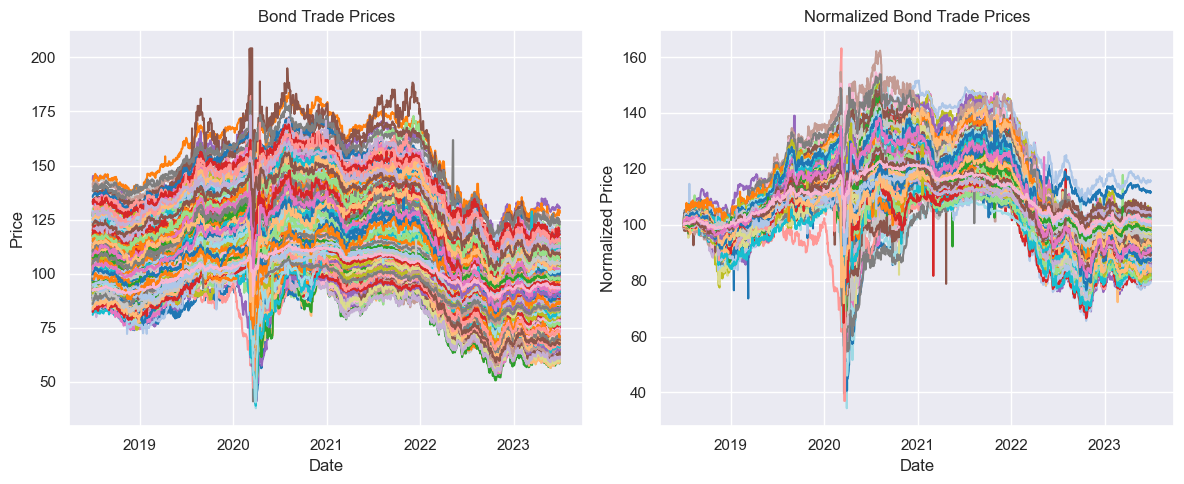

In [566]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(df_daily)
ax[0].set_title("Bond Trade Prices")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid(True)

ax[1].plot(df_daily/df_daily.iloc[0] * 100)
ax[1].set_title("Normalized Bond Trade Prices")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Normalized Price")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [567]:
df_daily_returns = df_daily.pct_change()
df_daily_returns.head()

cusip       00130HCG8  00130HCH6  00206RBH4  00206RBK7  00206RCP5  00206RCQ3  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN   0.007999   0.006836   0.009779  -0.012479   
2018-07-05        NaN        NaN  -0.001048   0.001358  -0.000728   0.021924   
2018-07-06        NaN        NaN   0.022426   0.007332  -0.003023  -0.013728   
2018-07-09        NaN        NaN   0.008142   0.007759   0.004086   0.004256   

cusip       00206RCU4  00206RDJ8  00206RDK5  00206RDQ2  00206RDR0  00206RGL0  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03   0.010676  -0.015369  -0.003213   0.003484   0.008751        NaN   
2018-07-05   0.004343   0.005586   0.011768   0.014205   0.005707        NaN   
2018-07-06   0.000000   0.003694   0.007163  -0.010524  -0.000429        NaN   
2018-07-09   0.004119   0.006324   0.000000   0.013682   0.006205        NaN   

cusip       00206RGQ9  00206RHJ4  00206RHK1  00206RHW5  00206RJX1  00206RJY9  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RJZ6  00206RKA9  00206RKB7  00206RKE1  00206RKG6  00206RKH4  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RKJ0  00206RLJ9  00206RLV2  00206RMM1  00206RMN9  00206RMT6  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00217GAB9  00217GAC7  002824BF6  002824BG4  002824BH2  00287YAM1  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN   0.003940   0.002800   0.010864   0.001018   
2018-07-05        NaN        NaN   0.000010   0.007810   0.001455   0.007317   
2018-07-06        NaN        NaN   0.005071   0.002312   0.006312   0.000000   
2018-07-09        NaN        NaN  -0.001554  -0.000131   0.002831  -0.002165   

cusip       00287YAR0  00287YAS8  00287YAV1  00287YAW9  00287YBD0  00287YBF5  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03   0.002691   0.000000   0.007054   0.000000        NaN        NaN   
2018-07-05   0.010439   0.005158   0.003789   0.012952        NaN        NaN   
2018-07-06   0.002012   0.000000   0.008643   0.002084        NaN        NaN   
2018-07-09  -0.003976   0.000000   0.019424   0.002825        NaN        NaN   

cusip       00287YBV0  00287YBX6  00287YCA5  00287YCB3  00287YCY3  00287Y

# Daily Prices

In [688]:
df_characteristics_full = df_characteristics[df_characteristics["Effective_Date"] < pd.Timestamp("2018-07-01")]
df_characteristics_full = df_characteristics_full.reset_index().drop(["index"], axis = 1)
df_characteristics_full.head()

Name      Cusip   Maturity      TTM  Coupon  \
0         GOLDMAN SACHS GROUP INC/THE  38141GFD1 2037-10-01  13.9123    6.75   
1                     CVS HEALTH CORP  126650CZ1 2048-03-25  24.4000    5.05   
2  DEUTSCHE TELEKOM INTERNATIONAL FIN  25156PAC7 2030-06-15   6.6110    8.75   
3      BRITISH TELECOMMUNICATIONS PLC  111021AE1 2030-12-15   7.1123    9.63   
4                BANK OF AMERICA CORP  06051GHD4 2028-12-20   5.1260    3.42   

   Weight  Amount_Issued               Industry        Location Accrual_Date  \
0    0.25     5545000000                Banking   United States   2007-10-03   
1    0.22     8000000000  Consumer Non-Cyclical   United States   2018-03-09   
2    0.21     3500000000         Communications         Germany   2000-07-06   
3    0.16     2800000000         Communications  United Kingdom   2000-12-12   
4    0.15     5437485000                Banking   United States   2017-12-20   

  Effective_Date Moody_Rating S&P_Rating Fitch_Rating    TTM_Range      TFI  \
0     2007-10-03         Baa2        BBB         BBB+  10-15 Years  16.1041   
1     2018-03-09         Baa2        BBB         None    20+ Years   5.6658   
2     2000-07-06         Baa1       BBB+         BBB+    5-7 Years  23.3507   
3     2000-12-12         Baa2        BBB          BBB   7-10 Years  22.9151   
4     2018-05-22           A3       BBB+         None    5-7 Years   5.4630   

                          Company Ticker          Sector Sector Ticker  
0                   Goldman Sachs     GS      Financials           XLK  
1                      Cvs Health    CVS     Health Care           XLF  
2  Deutsche Telekom International  DTEGY  Communications           XLY  
3      British Telecommunications  BTGOF  Communications           XLY  
4                 Bank Of America    BAC      Financials           XLK

In [689]:
len(df_characteristics_full)

755

In [690]:
full_data = df_characteristics[df_characteristics["Effective_Date"] < pd.Timestamp("2018-07-01")]["Cusip"]
full_data = [i for i in full_data if i not in ['161175BK9', '161175BJ2']]

In [691]:
df_characteristics_full = df_characteristics_full[df_characteristics_full["Cusip"].isin(full_data)]
df_characteristics_full.head()

Name      Cusip   Maturity      TTM  Coupon  \
0         GOLDMAN SACHS GROUP INC/THE  38141GFD1 2037-10-01  13.9123    6.75   
1                     CVS HEALTH CORP  126650CZ1 2048-03-25  24.4000    5.05   
2  DEUTSCHE TELEKOM INTERNATIONAL FIN  25156PAC7 2030-06-15   6.6110    8.75   
3      BRITISH TELECOMMUNICATIONS PLC  111021AE1 2030-12-15   7.1123    9.63   
4                BANK OF AMERICA CORP  06051GHD4 2028-12-20   5.1260    3.42   

   Weight  Amount_Issued               Industry        Location Accrual_Date  \
0    0.25     5545000000                Banking   United States   2007-10-03   
1    0.22     8000000000  Consumer Non-Cyclical   United States   2018-03-09   
2    0.21     3500000000         Communications         Germany   2000-07-06   
3    0.16     2800000000         Communications  United Kingdom   2000-12-12   
4    0.15     5437485000                Banking   United States   2017-12-20   

  Effective_Date Moody_Rating S&P_Rating Fitch_Rating    TTM_Range      TFI  \
0     2007-10-03         Baa2        BBB         BBB+  10-15 Years  16.1041   
1     2018-03-09         Baa2        BBB         None    20+ Years   5.6658   
2     2000-07-06         Baa1       BBB+         BBB+    5-7 Years  23.3507   
3     2000-12-12         Baa2        BBB          BBB   7-10 Years  22.9151   
4     2018-05-22           A3       BBB+         None    5-7 Years   5.4630   

                          Company Ticker          Sector Sector Ticker  
0                   Goldman Sachs     GS      Financials           XLK  
1                      Cvs Health    CVS     Health Care           XLF  
2  Deutsche Telekom International  DTEGY  Communications           XLY  
3      British Telecommunications  BTGOF  Communications           XLY  
4                 Bank Of America    BAC      Financials           XLK

In [692]:
df_characteristics_full.to_pickle("df_characteristics_full.pkl")

In [693]:
df_daily_full = df_daily[full_data]
df_daily_full.head()

cusip        38141GFD1   126650CZ1  25156PAC7   111021AE1  06051GHD4  \
trd_dt                                                                 
2018-07-02  118.760000  101.232000   133.2860         NaN  93.902000   
2018-07-03  119.420451  102.339000   134.2339  142.980031  94.490971   
2018-07-05  119.789000  103.208613   134.1030  143.156000  94.386000   
2018-07-06  120.170000  103.143394   134.1030  143.156000  94.447000   
2018-07-09  120.689000  103.495000   134.6330  143.177000  94.550000   

cusip       126650CX6  35177PAL1   377372AE7   126650CY4  046353AD0  \
trd_dt                                                                
2018-07-02     98.516    138.237  127.204750   99.096000        NaN   
2018-07-03     99.002    138.237  129.540000   99.615772        NaN   
2018-07-05     99.326    138.618  130.083705  100.097656    124.738   
2018-07-06     99.544    138.618  130.511000  100.279000    124.738   
2018-07-09     99.405    138.618  130.537000  100.173000    124.867   

cusip       852060AT9   037833BX7  172967KA8  913017BT5  38141GWZ3  717081CY7  \
trd_dt                                                                          
2018-07-02    104.405  107.682000     97.874     98.669  98.430000  138.56700   
2018-07-03    106.397  108.659748     98.024     99.315  98.939003  138.56700   
2018-07-05    106.700  109.041000     98.830     99.384  98.964000  139.46073   
2018-07-06    106.170  109.111000     98.714     99.938  99.059000  140.33200   
2018-07-09    107.079  109.607902     98.988    100.112  99.020000  140.81300   

cusip       023135BC9  822582AD4  36186CBY8  437076AS1   126650CN8  617482V92  \
trd_dt                                                                          
2018-07-02        NaN    130.150    118.033    122.519  100.500000    122.870   
2018-07-03     95.912    128.500    119.028    122.092  102.669000    123.150   
2018-07-05     96.465    130.788    118.875    122.697  102.200000    123.921   
2018-07-06     96.633    130.609    118.875    124.117  103.529000    124.923   
2018-07-09     96.543    130.132    119.003    123.908  103.526667    124.923   

cusip       539439AQ2   92826CAF9  87938WAC7   404280BT5   031162CF5  \
trd_dt                                                                 
2018-07-02     92.299  104.394000        NaN  100.682000   98.965000   
2018-07-03     92.732  104.617000    120.677  101.293513   99.380000   
2018-07-05     93.041  106.442500    122.234  101.153000  100.154853   
2018-07-06     93.041  106.054000    122.234  101.402000  100.397000   
2018-07-09     93.204  106.311328    122.214  101.482000  100.918000   

cusip        38141GGM0   161175BA1   983024AN0  46625HRY8   46625HHF0  \
trd_dt                                                                  
2018-07-02  117.488000  105.724000  122.238983     97.128         NaN   
2018-07-03  118.027000  105.839525  123.008000     97.623  123.196658   
2018-07-05  118.894012  106.358000  123.446000     97.805  123.931000   
2018-07-06  118.894012  106.957000  123.650000     97.630  125.031000   
2018-07-09  118.956800  107.307000  124.249000     98.105  123.420500   

cusip       00287YAM1  023135BJ4  172967EW7  17275RAF9   233835AQ0  61744YAP3  \
trd_dt                                                                          
2018-07-02     95.296     97.653    141.498  119.73200  140.100000  96.254000   
2018-07-03     95.393    100.849    141.498  119.73200  142.262000  96.772119   
2018-07-05     96.091     99.184    141.498  120.57900  141.729708  96.667000   
2018-07-06     96.091    100.199    143.601  120.48000  141.729708  96.893000   
2018-07-09     95.883    100.487    144.468  120.60145  141.456000  96.771000   

cusip       404280BK4  46647PAF3   002824BH2  38141GWV2  949746RF0  06738EAW5  \
trd_dt                                                                          
2018-07-02     97.243     95.485  107.826000     95.243    108.146     94.401   
2018-07-03     97.264     96.123 

In [49]:
df_daily_full.to_pickle("df_daily.pkl")

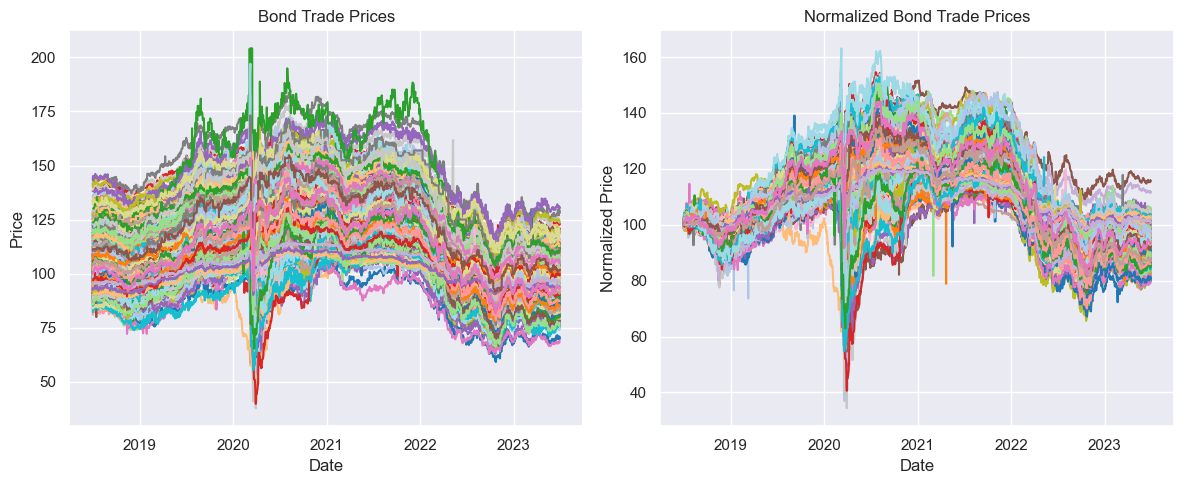

In [82]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(df_daily_full)
ax[0].set_title("Bond Trade Prices")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid(True)

ax[1].plot(df_daily_full/df_daily_full.iloc[0] * 100)
ax[1].set_title("Normalized Bond Trade Prices")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Normalized Price")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [51]:
df_daily_returns_full = df_daily_full.pct_change()
df_daily_returns_full = df_daily_returns_full.iloc[1:]
df_daily_returns_full = df_daily_returns_full.fillna(0)
df_daily_returns_full.head()

cusip       38141GFD1  126650CZ1  25156PAC7  111021AE1  06051GHD4  126650CX6  \
trd_dt                                                                         
2018-07-03   0.005561   0.010935   0.007112   0.000000   0.006272   0.004933   
2018-07-05   0.003086   0.008497  -0.000975   0.001231  -0.001111   0.003273   
2018-07-06   0.003181  -0.000632   0.000000   0.000000   0.000646   0.002195   
2018-07-09   0.004319   0.003409   0.003952   0.000147   0.001091  -0.001396   
2018-07-10   0.000240   0.001132  -0.000208   0.001578   0.000127  -0.000724   

cusip       35177PAL1  377372AE7  126650CY4  046353AD0  852060AT9  037833BX7  \
trd_dt                                                                         
2018-07-03   0.000000   0.018358   0.005245   0.000000   0.019080   0.009080   
2018-07-05   0.002756   0.004197   0.004837   0.000000   0.002848   0.003509   
2018-07-06   0.000000   0.003285   0.001812   0.000000  -0.004967   0.000642   
2018-07-09   0.000000   0.000199  -0.001057   0.001034   0.008562   0.004554   
2018-07-10  -0.000209  -0.003769   0.003434   0.002330  -0.002606   0.005384   

cusip       172967KA8  913017BT5  38141GWZ3  717081CY7  023135BC9  822582AD4  \
trd_dt                                                                         
2018-07-03   0.001533   0.006547   0.005171   0.000000   0.000000  -0.012678   
2018-07-05   0.008222   0.000695   0.000253   0.006450   0.005766   0.017805   
2018-07-06  -0.001174   0.005574   0.000960   0.006247   0.001742  -0.001369   
2018-07-09   0.002776   0.001741  -0.000394   0.003428  -0.000931  -0.003652   
2018-07-10   0.000707  -0.001428  -0.000798  -0.003086   0.001025   0.000638   

cusip       36186CBY8  437076AS1  126650CN8  617482V92  539439AQ2  92826CAF9  \
trd_dt                                                                         
2018-07-03   0.008430  -0.003485   0.021582   0.002279   0.004691   0.002136   
2018-07-05  -0.001285   0.004955  -0.004568   0.006261   0.003332   0.017449   
2018-07-06   0.000000   0.011573   0.013004   0.008086   0.000000  -0.003650   
2018-07-09   0.001077  -0.001684  -0.000023   0.000000   0.001752   0.002426   
2018-07-10   0.004176  -0.003971   0.006052   0.004283  -0.000612   0.000912   

cusip       87938WAC7  404280BT5  031162CF5  38141GGM0  161175BA1  983024AN0  \
trd_dt                                                                         
2018-07-03   0.000000   0.006074   0.004193   0.004588   0.001093   0.006291   
2018-07-05   0.012902  -0.001387   0.007797   0.007346   0.004899   0.003561   
2018-07-06   0.000000   0.002462   0.002418   0.000000   0.005632   0.001653   
2018-07-09  -0.000164   0.000789   0.005189   0.000528   0.003272   0.004844   
2018-07-10   0.000000  -0.000641   0.000738   0.004062   0.008172   0.000000   

cusip       46625HRY8  46625HHF0  00287YAM1  023135BJ4  172967EW7  17275RAF9  \
trd_dt                                                                         
2018-07-03   0.005096   0.000000   0.001018   0.032728   0.000000   0.000000   
2018-07-05   0.001864   0.005961   0.007317  -0.016510   0.000000   0.007074   
2018-07-06  -0.001789   0.008876   0.000000   0.010234   0.014862  -0.000821   
2018-07-09   0.004865  -0.012881  -0.002165   0.002874   0.006038   0.001008   
2018-07-10  -0.002589   0.016468   0.005329  -0.000806   0.006050   0.003278   

cusip       233835AQ0  61744YAP3  404280BK4  46647PAF3  002824BH2  38141GWV2  \
trd_dt                                                                         
2018-07-03   0.015432   0.005383   0.000216   0.006682   0.010864   0.003402   
2018-07-05  -0.003742  -0.001086   0.006097  -0.008624   0.001455   0.002940   
2018-07-06   0.000000   0.002338  -0.000766   0.006464   0.006312  -0.002160   
2018-07-09  -0.001931  -0.001259  -0.000358   0.002273   0.002831   0.001297   
2018-07-10   0.000000  -0.000072   0.000440   0.000531   0.006721   0.001055   

cusip       949746RF0  06738EAW5  172967LD1  20030NBH3  50077LAB2  037833

In [52]:
df_daily_returns_full.to_pickle("df_daily_returns.pkl")

In [98]:
full_tickers = list(df_characteristics_full["Ticker"].unique())
full_tickers = [i for i in full_tickers if i not in [None, 'RABO.AS', 'DISCA', 'ENBL', 'CLR']]
full_tickers.sort()

In [503]:
df_close_full = df_close[full_tickers]
df_close_full = df_close_full.drop([pd.Timestamp("2022-12-30")])
df_close_full.head()

AAPL       ABBV        ABT        ADI        AER  \
Date                                                                         
2018-07-02 00:00:00  44.660526  72.200851  55.612400  87.108955  53.770000   
2018-07-03 00:00:00  43.882687  72.588554  55.439175  85.480942  54.139999   
2018-07-05 00:00:00  44.235817  73.263176  55.913250  87.190369  54.480000   
2018-07-06 00:00:00  44.849014  75.155235  56.669937  87.913948  54.590000   
2018-07-09 00:00:00  45.471741  75.248299  56.925217  87.895851  55.349998   

                           AIG       ALLY       AMAT        AMGN         AMT  \
Date                                                                           
2018-07-02 00:00:00  46.011150  22.660580  42.799240  158.088074  128.505890   
2018-07-03 00:00:00  46.278454  22.575615  41.974743  158.446426  127.049103   
2018-07-05 00:00:00  46.494022  22.771036  42.574375  159.854218  129.394165   
2018-07-06 00:00:00  46.882042  22.898485  43.220867  162.968353  129.518509   
2018-07-09 00:00:00  47.908157  23.552731  43.586262  165.664444  126.294052   

                          AMZN  ATH-PA        ATO        AVGO        AWK  \
Date                                                                       
2018-07-02 00:00:00  85.689003     NaN  79.792389  202.352249  78.946709   
2018-07-03 00:00:00  84.697998     NaN  80.613823  200.044891  79.468063   
2018-07-05 00:00:00  84.986504     NaN  81.302734  205.152817  80.099213   
2018-07-06 00:00:00  85.531502     NaN  81.762039  207.058853  80.931602   
2018-07-09 00:00:00  86.950996     NaN  79.324272  206.849869  78.004578   

                           AXP        AZN        BAC  BAM        BCE  \
Date                                                                   
2018-07-02 00:00:00  91.516800  30.145592  24.978146  NaN  31.111845   
2018-07-03 00:00:00  90.444458  30.093647  24.536524  NaN  31.365973   
2018-07-05 00:00:00  91.409325  30.240822  24.660177  NaN  31.473774   
2018-07-06 00:00:00  91.400047  30.457264  24.757332  NaN  32.066753   
2018-07-09 00:00:00  92.689583  30.613106  25.658243  NaN  31.966640   

                          BCS         BDX        BHF        BHP        BIIB  \
Date                                                                          
2018-07-02 00:00:00  8.183776  217.288879  40.779999  33.283802  295.769989   
2018-07-03 00:00:00  8.142651  218.725922  40.599998  33.379738  293.510010   
2018-07-05 00:00:00  8.257801  220.272156  41.430000  33.366039  298.809998   
2018-07-06 00:00:00  8.266025  220.890656  41.709999  33.975929  357.480011   
2018-07-09 00:00:00  8.364723  222.527817  43.290001  34.832523  354.000000   

                            BK        BKR         BP       BRK-B     BTGOF  \
Date                                                                         
2018-07-02 00:00:00  46.011013  27.854950  33.766666  187.830002  2.256670   
2018-07-03 00:00:00  45.245438  28.150921  34.289608  186.020004  2.256670   
2018-07-05 00:00:00  45.253944  28.117092  34.364304  187.500000  2.295179   
2018-07-06 00:00:00  45.253944  28.472258  34.319485  187.559998  2.295179   
2018-07-09 00:00:00  46.028030  29.123383  34.812538  189.639999  2.403007   

                           BUD         BXP          C        CAH         CAT  \
Date                                                                           
2018-07-02 00:00:00  93.191269   99.711426  55.240471  40.918034  119.165649   
2018-07-03 00:00:00  93.960136   99.623474  54.335682  41.209412  117.014725   
2018-07-05 00:00:00  94.877235  100.814964  54.746952  41.658978  118.745926   
2018-07-06 00:00:00  96.192650  100.998894  55.224010  41.575718  118.396233   
2018-07-09 00:00:00  96.164856  100.790993  56.704556  41.842125  123.257637   

                             CB        CCI         CF        CHTR      CMCSA  \
Date                                                                           
2018-07-02 00:00:00  114.361275  89.186607  38.022079  293

In [505]:
df_volume_full = df_volume[full_tickers]
df_volume_full = df_volume_full.drop([pd.Timestamp("2022-12-30")])
df_volume_full.head()

AAPL     ABBV      ABT      ADI      AER      AIG  \
Date                                                                         
2018-07-02 00:00:00  70925200  3854500  4365200  2058400  1224800  5198800   
2018-07-03 00:00:00  55819200  2452400  2245200   876000   509300  1970500   
2018-07-05 00:00:00  66416800  4744000  4065200  1977700  1197000  2743800   
2018-07-06 00:00:00  69940800  5867400  3647900  1551000   824600  2212400   
2018-07-09 00:00:00  79026400  5953100  3654900  1861300   941600  4706400   

                        ALLY      AMAT     AMGN      AMT      AMZN  ATH-PA  \
Date                                                                         
2018-07-02 00:00:00  4001000  11042900  2069800  1559500  63714000     NaN   
2018-07-03 00:00:00  1143100   7538500  1348000  1669600  43546000     NaN   
2018-07-05 00:00:00  2933200   8950700  1801000  1512400  59662000     NaN   
2018-07-06 00:00:00  2047500  11467600  2751600  1376600  53006000     NaN   
2018-07-09 00:00:00  3105200   9727700  3065500  2334400  60240000     NaN   

                        ATO     AVGO     AWK      AXP      AZN       BAC  BAM  \
Date                                                                            
2018-07-02 00:00:00  353200  3336900  674900  3148700  4119700  52534300  NaN   
2018-07-03 00:00:00  373600  1159100  336000  2041200  1909600  40599000  NaN   
2018-07-05 00:00:00  328000  2529900  682700  2385500  3715700  44506800  NaN   
2018-07-06 00:00:00  271100  2311200  608300  1996600  2736100  39424900  NaN   
2018-07-09 00:00:00  564400  1795500  869400  4991700  2062500  61758900  NaN   

                         BCE      BCS     BDX      BHF      BHP      BIIB  \
Date                                                                        
2018-07-02 00:00:00   654100  2289600  827893  2140000  3397751   1116400   
2018-07-03 00:00:00   605800  1433000  696795   685000  1872631    452900   
2018-07-05 00:00:00  1541800  1921900  978875  1497700  2481446    746300   
2018-07-06 00:00:00  1442200  1312700  837733  1216300  2587829  12857000   
2018-07-09 00:00:00   843800  1861000  947920  1997500  2165996   3872800   

                          BK      BKR       BP    BRK-B  BTGOF      BUD  \
Date                                                                      
2018-07-02 00:00:00  4303100  3634600  4149900  3521000      0  1265200   
2018-07-03 00:00:00  2600900  2004600  3346600  2031200      0   789600   
2018-07-05 00:00:00  2976600  2406100  5301000  3310200   6700  1118800   
2018-07-06 00:00:00  3292900  2491800  2933500  2818800      0  1506700   
2018-07-09 00:00:00  2849600  2481900  5192400  3504700    100  1120200   

                        BXP         C      CAH      CAT       CB      CCI  \
Date                                                                        
2018-07-02 00:00:00  688900  12699100  3679400  3172600  1195100  2178600   
2018-07-03 00:00:00  397200  12346000  1857800  1837400  1171200  2165200   
2018-07-05 00:00:00  719800  12359000  3663000  3366300  1642500  2311300   
2018-07-06 00:00:00  478000  13174900  4756000  3179600  1393300  1795800   
2018-07-09 00:00:00  574500  15148500  3849900  5562300  1882400  2164600   

                          CF     CHTR     CMCSA      CME      CNQ      COF  \
Date                                                                         
2018-07-02 00:00:00  3049100   909600  17165000   917800  3178781  2460400   
2018-07-03 00:00:00  1363000   664300  12660800   512000  2688803   871100   
2018-07-05 00:00:00  3234600  1085000  11330300  1334500  3091282  1447700   
2018-07-06 00:00:00  2979100  1119300  11541300  1574300  2085903  1359100   
2018-07-09 00:00:00  2168800   900100  13664900  1651900  2926288  3123300   

                         COP      COR     COST       CP      CPB      CRM  \
Date                                                                        
2018-07-02 00:00:00  4952800  1260100  1876100  1517500 

In [506]:
first_non_null_values_full = {}
for column in df_close_full.columns:
    first_non_null_index = df_close_full[column].first_valid_index()
    if first_non_null_index is not None:
        first_non_null_values_full[column] = df_close_full.at[first_non_null_index, column]

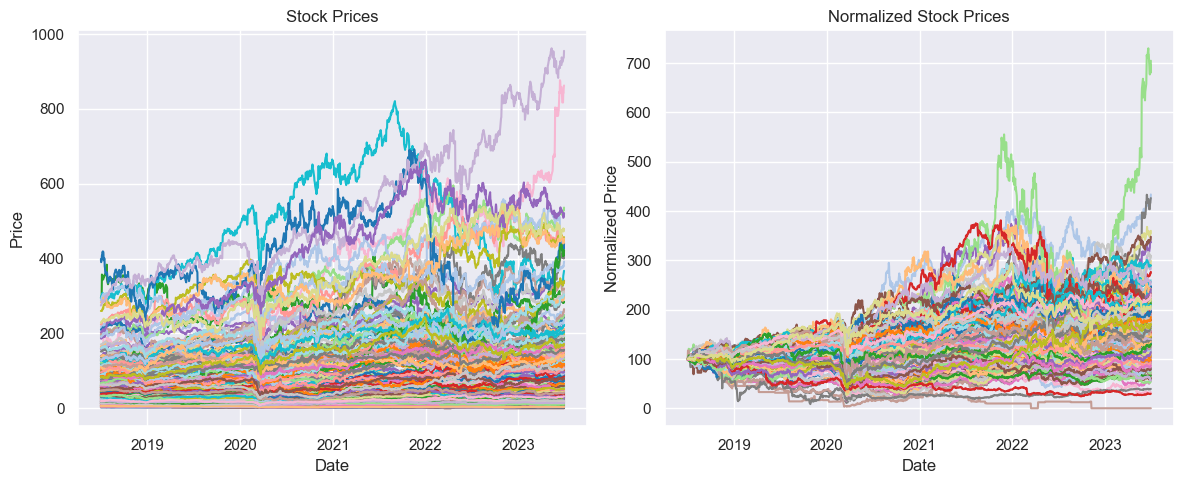

In [507]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(df_close_full)
ax[0].set_title("Stock Prices")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid(True)

df_stocks_normalized_full = df_close_full.dropna(axis = 1, how = "all") / first_non_null_values_full.values() * 100
for i in range(len(df_stocks_normalized_full.columns)):
    ax[1].plot(df_stocks_normalized_full.index, df_stocks_normalized_full[df_stocks_normalized_full.columns[i]], c = c20[(i+1)%20])
ax[1].set_title("Normalized Stock Prices")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Normalized Price")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [606]:
daily_volume = data[["trd_dt", "volume", "cusip"]].groupby(["trd_dt", "cusip"]).sum()
daily_volume.head()

volume
trd_dt     cusip               
2018-07-02 00206RBH4  2643000.0
           00206RBK7  5702000.0
           00206RCP5   760000.0
           00206RCQ3  1662000.0
           00206RCU4   453000.0

In [314]:
daily_trades = data[["trd_dt", "volume", "cusip"]].groupby(["trd_dt", "cusip"]).count()
daily_trades.head()

volume
trd_dt     cusip            
2018-07-02 00206RBH4      13
           00206RBK7       6
           00206RCP5      13
           00206RCQ3      19
           00206RCU4      14

# Constructing Individual Bond Data

## Daily Bond Factors

- Daily bond factors are evaluated over train and test period and can be used to train models during the training period and predict bond returns during the testing period

In [675]:
def ytm(price, ttm, c):

    if price is None:
        return None

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    time = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    
    def f(y):
        return sum([coupon/(1 + y) ** t for t in time]) + 100 / (1 + y)**ttm - price

    max_iterations = 50 
    
    try:
        return newton(f, c, maxiter=max_iterations)
    except RuntimeError:
        return None


In [674]:
def closest_treasury(ttm):
    treasuries = [1, 2, 3, 5, 7, 10, 30]
    return min(treasuries, key = lambda x : abs(x - ttm))

In [673]:
def PV(ttm, c, date):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    r = macro_factors[str(closest_treasury(ttm)) + "YRT"][date]/100

    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"] / ((1 + r) ** df["Time"])

    return sum(df["PV"])

In [672]:
def macaulay_duration(price, ttm, c, date):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    r = macro_factors[str(closest_treasury(ttm)) + "YRT"][date]/100

    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"]/((1 + r)**df["Time"])
    df["Weight"] = df["PV"]/sum(df["PV"]) 

    duration = sum(df["Weight"]*df["Time"])
    return duration

In [671]:
def DV01(price, ttm, c, date):

    duration = macaulay_duration(price, ttm, c, date)

    if duration is None:
        return None
    else:
        return -1 * price * duration * .001

In [670]:
def convexity(price, ttm, c, date):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    r = macro_factors[str(closest_treasury(ttm)) + "YRT"][date]/100
    
    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"] /((1 + r) ** df["Time"])
    df["Weight"] = df["PV"]/sum(df["PV"]) 

    convexity = sum(df["Weight"]*(df["Time"]**2))
    return convexity

## Bond Level Factors

- Bond level factors evaluated over training period and can be used for classification

In [109]:
train_end = pd.Timestamp("2022-05-31")
len(df_daily[:train_end])

986

In [110]:
test_start = pd.Timestamp("2022-06-01")
len(df_daily[test_start:])

271

In [39]:
def illiquidity(bond):
    df = pd.DataFrame({"Price": bond})
    df["delta_t"] = df["Price"] - df["Price"].shift(1)
    df["delta_t1"] = df["Price"].shift(-1) - df["Price"]
    return -df["delta_t"].cov(df["delta_t1"])

In [41]:
def roll_illiquidity(bond):
    df = pd.DataFrame({"Price": bond})
    df["rd"] = df["Price"] - df["Price"].shift(1)
    df["rd1"] = df["rd"].shift()
    cov = -df["rd"].cov(df["rd1"])
    if cov < 0:
        return 0
    else:
        return 2*np.sqrt(cov)

In [676]:
def zero_return(returns):
    df = pd.DataFrame({"Returns": returns})
    return len(df[df["Returns"] == 0])/len(returns)

## Construct Factor Dataframe

In [644]:
df_characteristics_full = df_characteristics_full.sort_values("Cusip")
df_characteristics_full.head()

Name      Cusip   Maturity      TTM  Coupon  Weight  Amount_Issued  \
279  AT&T INC  00206RBH4 2042-12-15  19.1260    4.30    0.04      750000000   
463  AT&T INC  00206RBK7 2045-06-15  21.6274    4.35    0.03      900000000   
61   AT&T INC  00206RCP5 2035-05-15  11.5342    4.50    0.07     2250000000   
167  AT&T INC  00206RCQ3 2046-05-15  22.5425    4.75    0.05     1727815000   
595  AT&T INC  00206RCU4 2047-02-15  23.2986    5.65    0.02     1500000000   

           Industry Accrual_Date Effective_Date Moody_Rating S&P_Rating  \
279  Communications   2013-06-15     2013-06-18         Baa3       BBB-   
463  Communications   2013-06-15     2013-06-18          Aa2         A+   
61   Communications   2015-05-04     2015-05-04           A3       BBB+   
167  Communications   2015-05-04     2015-05-04         Baa1       BBB+   
595  Communications   2016-02-09     2016-02-09           A3         A-   

    Fitch_Rating    TTM_Range      TFI Company Ticker          Sector  \
279         BBB-  15-20 Years  10.3863    At&T      T  Communications   
463         None    20+ Years  10.3863    At&T      T  Communications   
61             A  10-15 Years   8.5096    At&T      T  Communications   
167         None    20+ Years   8.5096    At&T      T  Communications   
595            A    20+ Years   7.7397    At&T      T  Communications   

    Sector Ticker  
279           XLY  
463           XLY  
61            XLY  
167           XLY  
595           XLY

In [645]:
data_full = data[data["cusip"].isin(df_characteristics_full["Cusip"])]
data_full.head()

cusip        trd_datetime     trd_dt  trd_px     volume
0  871829BF3 2018-07-01 23:50:32 2018-07-02  94.111  5000000.0
1  98978VAL7 2018-07-02 01:17:48 2018-07-02  92.248  5000000.0
2  037833DB3 2018-07-02 02:37:16 2018-07-02  95.090    10000.0
3  606822AR5 2018-07-02 02:43:56 2018-07-02  95.448   100000.0
4  172967KA8 2018-07-02 03:35:11 2018-07-02  98.817   110000.0

In [702]:
df = data_full.groupby(["trd_dt", "cusip"]).agg({"trd_px": "last", "volume": ["sum", "count"]})
df.columns = ["Price", "Volume", "Trades"]
df["Return"] = df.groupby(level='cusip')['Price'].pct_change().fillna(0)
df.head()

Price     Volume  Trades  Return
trd_dt     cusip                                         
2018-07-02 00206RBH4   86.1320  2643000.0      13     0.0
           00206RBK7   85.2800  5702000.0       6     0.0
           00206RCP5   92.4460   760000.0      13     0.0
           00206RCQ3   91.4532  1662000.0      19     0.0
           00206RCU4  100.6970   453000.0      14     0.0

In [703]:
df.shape

(819933, 4)

In [704]:
dates = df_daily_returns.index
cusips = df.index.get_level_values('cusip').unique()
multi_index = pd.MultiIndex.from_product([dates, cusips], names=['trd_dt', 'cusip'])

In [705]:
df = df.reindex(multi_index)
df = df.reorder_levels(['cusip','trd_dt']).sort_index()
df.head()

Price     Volume  Trades    Return
cusip     trd_dt                                         
00206RBH4 2018-07-02  86.132  2643000.0    13.0  0.000000
          2018-07-03  86.821    49000.0     7.0  0.007999
          2018-07-05  86.730   951000.0    24.0 -0.001048
          2018-07-06  88.675   678000.0    11.0  0.022426
          2018-07-09  89.397  2900000.0     7.0  0.008142

In [706]:
prices = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i].ffill()
    prices.extend(df2["Price"])
df["Price"] = list(prices)

In [707]:
df.shape

(946521, 4)

In [708]:
def ticker_data(ticker, df, pct_change = True):
    if ticker not in df.columns:
        return [None] * 1257
    else:
        if pct_change == False:
            return df[ticker].fillna(0)
        else:
            return df[ticker].pct_change().fillna(0)

In [709]:
cpn, age, ttm, stock_return, stock_volume, etf_return = [], [], [], [], [], []

for i in df.index.droplevel(1).unique():
    cpn.extend([df_characteristics_full[df_characteristics_full["Cusip"] == i]["Coupon"].values[0]/100] * 1257)
    age.extend(list((df_daily.index - df_characteristics_full[df_characteristics_full["Cusip"] == i]["Effective_Date"].values[0]).days / 365))
    ttm.extend(list((df_characteristics_full[df_characteristics_full["Cusip"] == i]["Maturity"].values[0] - df_daily.index).days / 365))
    stock_return.extend(list(ticker_data(df_characteristics_full[df_characteristics_full["Cusip"] == i]["Ticker"].values[0], df_close_full)))
    stock_volume.extend(list(ticker_data(df_characteristics_full[df_characteristics_full["Cusip"] == i]["Ticker"].values[0], df_volume_full, pct_change = False)))
    etf_return.extend(list(ticker_data(df_characteristics_full[df_characteristics_full["Cusip"] == i]["Sector Ticker"].values[0], df_sector_etfs)))

cpn, age, ttm, stock_return, stock_volume, etf_return = list(cpn), list(age), list(ttm), list(stock_return), list(stock_volume), list(etf_return)

In [710]:
len(age)

946521

In [711]:
df["Coupon"] = cpn
df["Age"] = age
df["TTM"] = ttm
df["Stock_Return"] = stock_return
df["Stock_Volume"] = stock_volume
df["ETF_Return"] = etf_return
df.head()

Price     Volume  Trades    Return  Coupon       Age  \
cusip     trd_dt                                                              
00206RBH4 2018-07-02  86.132  2643000.0    13.0  0.000000   0.043  5.041096   
          2018-07-03  86.821    49000.0     7.0  0.007999   0.043  5.043836   
          2018-07-05  86.730   951000.0    24.0 -0.001048   0.043  5.049315   
          2018-07-06  88.675   678000.0    11.0  0.022426   0.043  5.052055   
          2018-07-09  89.397  2900000.0     7.0  0.008142   0.043  5.060274   

                            TTM  Stock_Return  Stock_Volume  ETF_Return  
cusip     trd_dt                                                         
00206RBH4 2018-07-02  24.471233      0.000000    50002449.0    0.000000  
          2018-07-03  24.468493      0.015523    44857650.0   -0.005025  
          2018-07-05  24.463014     -0.003363    46895286.0    0.004959  
          2018-07-06  24.460274      0.002454    54541518.0    0.007858  
          2018-07-09  24.452055      0.004123    57539848.0    0.011967

In [712]:
%%time

pv = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    pv.extend(df2.apply(lambda x: PV(x["TTM"], x["Coupon"], x.name), axis = 1).pct_change())
pv = list(pv)

CPU times: user 8min 32s, sys: 7.82 s, total: 8min 40s
Wall time: 8min 37s


In [713]:
ytms = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    ytms.extend(df2.apply(lambda x: ytm(x["Price"], x["TTM"], x["Coupon"]), axis = 1))
ytms = list(ytms)

In [714]:
durations = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    durations.extend(df2.apply(lambda x: macaulay_duration(x["Price"], x["TTM"], x["Coupon"], x.name), axis = 1))
durations = list(durations)

In [715]:
DV01s = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    DV01s.extend(df2.apply(lambda x: DV01(x["Price"], x["TTM"], x["Coupon"], x.name), axis = 1))
DV01s = list(DV01s)

In [716]:
convexitys = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    convexitys.extend(df2.apply(lambda x: convexity(x["Price"], x["TTM"], x["Coupon"], x.name), axis = 1))
convexitys = list(convexitys)

In [718]:
df["PV"] = pv
df["YTM"] = ytms
df["Duration"] = durations
df["DV01"] = DV01s
df["Convexity"] = convexitys
df = df.drop(["Coupon"], axis = 1)
df.head()

Price     Volume  Trades    Return       Age  \
cusip     trd_dt                                                      
00206RBH4 2018-07-02  86.132  2643000.0    13.0  0.000000  5.041096   
          2018-07-03  86.821    49000.0     7.0  0.007999  5.043836   
          2018-07-05  86.730   951000.0    24.0 -0.001048  5.049315   
          2018-07-06  88.675   678000.0    11.0  0.022426  5.052055   
          2018-07-09  89.397  2900000.0     7.0  0.008142  5.060274   

                            TTM  Stock_Return  Stock_Volume  ETF_Return  \
cusip     trd_dt                                                          
00206RBH4 2018-07-02  24.471233      0.000000    50002449.0    0.000000   
          2018-07-03  24.468493      0.015523    44857650.0   -0.005025   
          2018-07-05  24.463014     -0.003363    46895286.0    0.004959   
          2018-07-06  24.460274      0.002454    54541518.0    0.007858   
          2018-07-09  24.452055      0.004123    57539848.0    0.011967   

                            PV       YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                           
00206RBH4 2018-07-02       NaN  0.054010  16.324665 -1.406076  339.273017  
          2018-07-03  0.004849  0.053445  16.343155 -1.418929  339.790490  
          2018-07-05  0.001749  0.053541  16.344714 -1.417577  339.812463  
          2018-07-06  0.001668  0.051959  16.349071 -1.449754  339.925850  
          2018-07-09 -0.002931  0.051410  16.326755 -1.459563  339.254704

In [719]:
df.to_pickle("factor_df.pkl")

# Individual Bond Analysis

In [607]:
def bond_dataset(cusip):

    cusip_info = df_characteristics_full[df_characteristics_full["Cusip"] == cusip]
    
    df_cusip = pd.DataFrame({"Price": df_daily[cusip]})
    df_cusip["Return"] = df_cusip.pct_change().fillna(0)
    df_cusip["Volume"] = daily_volume.loc[(slice(None), cusip), :].droplevel(1)
    df_cusip["Trades"] = daily_trades.loc[(slice(None), cusip), :].droplevel(1)
    df_cusip["Age"] = df_cusip.index.map(lambda x: (x - cusip_info["Effective_Date"].values[0]).days/365)
    df_cusip["TTM"] = df_cusip.index.map(lambda x: (cusip_info["Maturity"].values[0] - x).days/365)
    df_cusip["PV"] = df_cusip.apply(lambda x: PV(x["TTM"], cusip_info["Coupon"].values[0]/100, x.name), axis = 1).pct_change()
    df_cusip["YTM"] = df_cusip.apply(lambda x: ytm(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["Duration"] = df_cusip.apply(lambda x: macaulay_duration(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["DV01"] = df_cusip.apply(lambda x: DV01(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["Convexity"] = df_cusip.apply(lambda x: convexity(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["Stock Return"] = df_close_full[cusip_info["Ticker"].values[0]].pct_change()
    df_cusip["Stock Volume"] = df_volume_full[cusip_info["Ticker"].values[0]]
    df_cusip["ETF Return"] = df_sector_etfs[cusip_info["Sector Ticker"].values[0]].pct_change()

    df_cusip = pd.concat([df_cusip, macro_factors.drop(["Lower_Target", "Upper_Target"], axis = 1).pct_change()], axis = 1)
    df_cusip = df_cusip.iloc[1:].fillna(0).drop(["Price"], axis = 1)
    df_cusip["Cusip"] = cusip
    df_cusip = df_cusip.set_index(['Cusip'], append=True)

    return df_cusip

In [609]:
bond_dataset("25156PAC7").head()

Return      Volume  Trades        Age        TTM  \
           Cusip                                                           
2018-07-03 25156PAC7  0.007112   7016000.0    10.0  18.002740  11.958904   
2018-07-05 25156PAC7 -0.000975     70000.0     3.0  18.008219  11.953425   
2018-07-06 25156PAC7  0.000000         0.0     0.0  18.010959  11.950685   
2018-07-09 25156PAC7  0.003952  12017000.0    13.0  18.019178  11.942466   
2018-07-10 25156PAC7 -0.000208   4130000.0     6.0  18.021918  11.939726   

                            PV       YTM  Duration      DV01  Convexity  \
           Cusip                                                          
2018-07-03 25156PAC7  0.003423  0.050218  8.251392 -1.107616  84.426540   
2018-07-05 25156PAC7 -0.000681  0.050377  8.243381 -1.105462  84.298633   
2018-07-06 25156PAC7  0.001747  0.050394  8.240411 -1.105064  84.250224   
2018-07-09 25156PAC7 -0.003102  0.049942  8.239360 -1.109290  84.221778   
2018-07-10 25156PAC7 -0.000754  0.049986  8.235867 -1.108589  84.165465   

                      Stock Return  Stock Volume  ETF Return  EFFR      1YRT  \
           Cusip                                                               
2018-07-03 25156PAC7      0.015554      103100.0   -0.005025   0.0 -0.004274   
2018-07-05 25156PAC7      0.026165       84800.0    0.004959   0.0 -0.004292   
2018-07-06 25156PAC7      0.008706       78800.0    0.007858   0.0  0.008621   
2018-07-09 25156PAC7      0.001233       75100.0    0.011967   0.0  0.000000   
2018-07-10 25156PAC7      0.001232      104000.0    0.002150   0.0  0.008547   

                          2YRT      3YRT      5YRT      7YRT     10YRT  \
           Cusip                                                         
2018-07-03 25156PAC7 -0.015564 -0.007547 -0.010909 -0.014134 -0.013937   
2018-07-05 25156PAC7  0.007905  0.007605  0.007353  0.003584  0.003534   
2018-07-06 25156PAC7 -0.007843 -0.003774 -0.010949 -0.007143 -0.007042   
2018-07-09 25156PAC7  0.015810  0.007576  0.014760  0.014388  0.014184   
2018-07-10 25156PAC7  0.007782  0.011278  0.007273  0.003546  0.003497   

                         30YRT       SPY       LQD  
           Cusip                                    
2018-07-03 25156PAC7 -0.010033 -0.003531  0.003677  
2018-07-05 25156PAC7 -0.003378  0.008158  0.003140  
2018-07-06 25156PAC7 -0.003390  0.008458  0.001391  
2018-07-09 25156PAC7  0.006803  0.009004  0.000695  
2018-07-10 25156PAC7  0.003378  0.003598 -0.001128

In [264]:
def plot_bond(cusip):

    cusip_info = df_characteristics[df_characteristics["Cusip"] == cusip]
    initial_ttm = (pd.Timestamp(cusip_info["Maturity"].values[0]) - pd.Timestamp(cusip_info["Effective_Date"].values[0])).days/365

    fig, ax = plt.subplots(2, 2, figsize = [12,8])

    ax[0,0].plot(data[data["cusip"] == cusip]["trd_datetime"], 
                 data[data["cusip"] == cusip]["trd_px"], 
                 label = "Trade Prices", color = c20[0])
    ax[0,0].plot(df_daily[cusip], label = "Daily Close Price", color = c20[1])
    ax[0,0].set_title(cusip_info["Ticker"].values[0] + " " + str(int(round(initial_ttm, 1))) + "YR Corporate Bond Price (" + cusip + ")")
    ax[0,0].set_xlabel("Date")
    ax[0,0].set_ylabel("Price")
    ax[0,0].legend(loc = "lower left")

    ax[0,1].hist(df_daily_returns[cusip], bins = 50, color = c20[0])
    ax[0,1].set_title(cusip_info["Ticker"].values[0] + " " + str(int(round(initial_ttm, 1))) + "YR Corporate Bond Returns (" + cusip + ")")
    ax[0,1].set_xlabel("Daily Return")
    ax[0,1].set_xlim(-.1, .1)

    df = df_daily[cusip].diff()
    df.iloc[0] = 0
    plot_acf(df, lags=50, ax=ax[1, 0])

    ax[1,1].plot(df_daily_returns.index, df_daily_returns[cusip], color = c20[0])
    ax[1,1].set_title("Daily Returns")
    ax[1,1].set_xlabel("Daily Return")


    plt.tight_layout()
    plt.show()

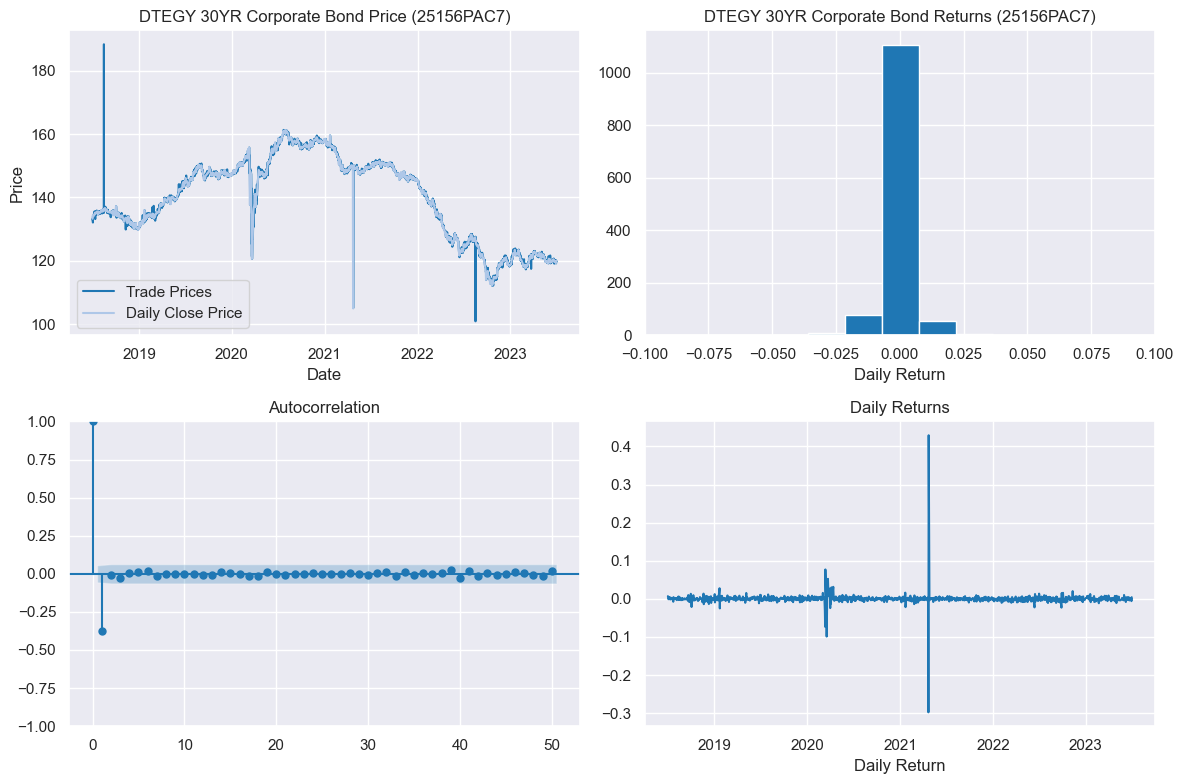

In [265]:
plot_bond("25156PAC7")